In [ ]:
!rm -rf /content/data_haptic
!unzip -q /content/data_haptic.zip -d /content/data_haptic
!ls /content/data_haptic

data_haptic


# **User Classification**

In [ ]:
!pip install scikit-learn==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.1 which is incompatible.
opencv-python-headless 4.

In [ ]:
!pip -q install imbalanced-learn==0.12.3 xgboost==2.1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.8 MB/s eta 0:00:00


In [ ]:
import warnings, os, sys, importlib
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
os.environ["XGBOOST_VERBOSITY"] = "0"

import sklearn

In [ ]:
import numpy as np, pandas as pd, glob
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

In [ ]:
ROOT = "/content/data_haptic/data_haptic"

SEED = 42
np.random.seed(SEED)

PRESET = "HIGH"
if PRESET.upper() == "FAST":
    WIN_S, HOP_S = 1.0, 0.8
    DEFAULT_FS   = 250.0
    DOWNSAMPLE   = 2
    MAX_WINS_PER_REC = 12
    OUTER_SPLITS     = 2
else:
    WIN_S, HOP_S = 1.4, 0.7
    DEFAULT_FS   = 250.0
    DOWNSAMPLE   = 1
    MAX_WINS_PER_REC = None
    OUTER_SPLITS     = 3

THRESH_CRITERION = "accuracy"
BASE_GATE_MIN    = 0.70
NEG_RATIO_GATE   = None

GATE_MODELS = ["XGBoost", "RandomForest", "ExtraTrees"]
ID_MODELS   = ["XGBoost", "ExtraTrees", "RandomForest", "LogReg"]

USE_SOFTVOTE     = True
SOFTVOTE_MEMBERS = ["XGBoost", "RandomForest", "ExtraTrees"]

In [ ]:
# Data Loading

def list_force_files(root):
    files=[]
    for u in sorted([d for d in os.listdir(root) if d.startswith("u")]):
        upath=os.path.join(root,u)
        if not os.path.isdir(upath): continue
        for t in list("abcdefg"):
            tpath=os.path.join(upath,t)
            if not os.path.isdir(tpath): continue
            f=os.path.join(tpath,"force.csv")
            if not os.path.exists(f):
                cands=glob.glob(os.path.join(tpath,"*force*.csv"))
                if not cands: continue
                f=sorted(cands)[0]
            files.append((u,t,f))
    return files

In [ ]:
def load_force_csv(path):
    df=pd.read_csv(path)
    num=df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] < 3: num=df
    cols={c.lower():c for c in num.columns}
    guess=list(num.columns[-3:])
    fx=cols.get("fx") or cols.get("force_x") or cols.get("forcex") or guess[0]
    fy=cols.get("fy") or cols.get("force_y") or cols.get("forcey") or guess[1]
    fz=cols.get("fz") or cols.get("force_z") or cols.get("forcez") or guess[2]
    tt=cols.get("time") or cols.get("timestamp")
    out=pd.DataFrame({"Fx":pd.to_numeric(num[fx],errors="coerce"),
                      "Fy":pd.to_numeric(num[fy],errors="coerce"),
                      "Fz":pd.to_numeric(num[fz],errors="coerce")})
    if tt is not None and tt in num.columns:
        out["time"]=pd.to_numeric(num[tt],errors="coerce")
    return out.dropna().reset_index(drop=True)

In [ ]:
def estimate_fs(df, default_fs=DEFAULT_FS, min_fs=20.0, max_fs=2000.0):
    if "time" not in df.columns or len(df["time"])<2: return float(default_fs)
    t=pd.to_numeric(df["time"],errors="coerce").to_numpy()
    dt=np.diff(t); dt=dt[np.isfinite(dt)&(dt>0)]
    if dt.size==0: return float(default_fs)
    med=float(np.median(dt))
    if not np.isfinite(med) or med<=0: return float(default_fs)
    return float(np.clip(1.0/med, min_fs, max_fs))

def window_indices(n, win, hop):
    starts=list(range(0, max(n-win+1,1), hop))
    if starts and starts[-1] != max(n-win,0): starts.append(max(n-win,0))
    return starts or [0]

In [ ]:
# Feature Extraction

EPS=1e-8
def stats_fast(x):
    x=np.asarray(x,np.float32); n=x.size
    if n==0: return (0,0,0,0,0,0,0,0,0,0)
    mu=float(x.mean()); sd=float(x.std())
    iqr=float(np.subtract(*np.percentile(x,[75,25]))) if n>1 else 0.0
    ptp=float(np.ptp(x)) if n>1 else 0.0
    rms=float(np.sqrt((x*x).mean())); mad=float(np.mean(np.abs(x-mu)))
    if sd>=EPS and n>3:
        c=x-mu; m2=float(np.mean(c*c)); m3=float(np.mean(c*c*c)); m4=float(np.mean(c**4))
        skew=float(m3/(m2**1.5+1e-12)); kurt=float(m4/(m2*m2+1e-12)-3.0)
    else: skew=0.0; kurt=0.0
    return (mu,sd,float(x.min()),float(x.max()),rms,iqr,ptp,mad,skew,kurt)

def corr_fast(a,b):
    a=np.asarray(a,np.float32); b=np.asarray(b,np.float32)
    n=min(a.size,b.size)
    if n<3: return 0.0
    a=a[:n]-float(a[:n].mean()); b=b[:n]-float(b[:n].mean())
    va=float(np.dot(a,a)/n); vb=float(np.dot(b,b)/n)
    if va<EPS or vb<EPS: return 0.0
    return float(np.dot(a,b)/n / (va**0.5*vb**0.5 + 1e-12))

def spec_fast(x, fs):
    x=np.asarray(x,np.float32)-np.float32(x.mean())
    nfft=min(256,len(x)) if len(x)>=32 else len(x)
    if nfft<16: return (0.0,0.0,0.0,0.0)
    X=np.fft.rfft(x, n=nfft); Pxx=(np.abs(X)**2).astype(np.float32)+1e-12
    f=np.fft.rfftfreq(nfft, d=1.0/max(fs,1e-6)).astype(np.float32)
    P=Pxx/Pxx.sum(); centroid=float((f*P).sum()); cdf=np.cumsum(P)
    roll85=float(f[np.searchsorted(cdf,0.85)]); roll95=float(f[np.searchsorted(cdf,0.95)])
    flat=float(np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx))
    return (centroid,roll85,roll95,flat)

def featurize_segment(seg, fs):
    Fx,Fy,Fz = seg[:,0], seg[:,1], seg[:,2]
    if DOWNSAMPLE>1:
        Fx,Fy,Fz = Fx[::DOWNSAMPLE], Fy[::DOWNSAMPLE], Fz[::DOWNSAMPLE]
        fs = fs / DOWNSAMPLE
    Vx=np.gradient(Fx,1/fs); Vy=np.gradient(Fy,1/fs); Vz=np.gradient(Fz,1/fs)
    Fn=np.sqrt(Fx*Fx+Fy*Fy+Fz*Fz); Vn=np.sqrt(Vx*Vx+Vy*Vy+Vz*Vz)
    feats={}
    for arr,name in [(Fx,'Fx'),(Fy,'Fy'),(Fz,'Fz'),(Fn,'Fn'),(Vn,'Vn')]:
        mu,sd,xmin,xmax,rms,iqr,ptp,mad,sk,ku = stats_fast(arr)
        feats.update({f"{name}_mean":mu, f"{name}_std":sd, f"{name}_min":xmin, f"{name}_max":xmax,
                      f"{name}_rms":rms, f"{name}_iqr":iqr, f"{name}_ptp":ptp, f"{name}_mad":mad,
                      f"{name}_skew":sk, f"{name}_kurt":ku})
    c,r85,r95,flat = spec_fast(Fn,fs); feats.update({"Fn_centroid":c,"Fn_roll85":r85,"Fn_roll95":r95,"Fn_flat":flat})
    c,r85,r95,flat = spec_fast(Vn,fs); feats.update({"Vn_centroid":c,"Vn_roll85":r85,"Vn_roll95":r95,"Vn_flat":flat})
    feats.update({"corr_FxFy":corr_fast(Fx,Fy),"corr_FxFz":corr_fast(Fx,Fz),"corr_FyFz":corr_fast(Fy,Fz)})
    return feats

def build_windows(root, win_s=WIN_S, hop_s=HOP_S):
    rows=[]
    for (u,t,fpath) in list_force_files(root):
        df=load_force_csv(fpath)
        fs=estimate_fs(df, default_fs=DEFAULT_FS)
        sig=df[["Fx","Fy","Fz"]].to_numpy(dtype=np.float32, copy=False)
        win=max(int(round(win_s*fs)),32); hop=max(int(round(hop_s*fs)),16)
        if len(sig)<win: win=max(len(sig),8); hop=max(win//2,1)
        starts=window_indices(len(sig),win,hop)
        if MAX_WINS_PER_REC and len(starts)>MAX_WINS_PER_REC:
            idx=np.linspace(0,len(starts)-1,MAX_WINS_PER_REC,dtype=int); starts=[starts[i] for i in idx]
        for k,st in enumerate(starts):
            seg=sig[st:st+win]
            if seg.shape[0]<8: continue
            feats=featurize_segment(seg,fs)
            feats.update({"user":u,"task":t,"record":fpath,"win_id":k})
            rows.append(feats)
    W=pd.DataFrame(rows).replace([np.inf,-np.inf],np.nan).fillna(0.0)
    task_ohe = pd.get_dummies(W["task"], prefix="task")
    W = pd.concat([W, task_ohe], axis=1)
    for base in ["Fn","Vn"]:
        for k in ["std","iqr","ptp","mad"]:
            W[f"{base}_rel_{k}"] = W[f"{base}_{k}"] / (W[f"{base}_mean"].abs() + 1e-6)
    W["Fx_prop"] = W["Fx_rms"].abs()/(W["Fn_rms"].abs()+1e-6)
    W["Fy_prop"] = W["Fy_rms"].abs()/(W["Fn_rms"].abs()+1e-6)
    W["Fz_prop"] = W["Fz_rms"].abs()/(W["Fn_rms"].abs()+1e-6)
    print(f"Windows: {W.shape} | unique records: {W['record'].nunique()} | users: {sorted(W['user'].unique())}")
    return W

def aggregate_records(W):
    meta_cols=["user","task","record"]
    feat_cols=[c for c in W.columns if c not in meta_cols+["win_id"]]
    R = pd.concat([
        W.groupby("record")[feat_cols].mean().add_suffix("__mean"),
        W.groupby("record")[feat_cols].std(ddof=0).add_suffix("__std"),
        W.groupby("record")[feat_cols].median().add_suffix("__median"),
        W.groupby("record")[feat_cols].min().add_suffix("__min"),
        W.groupby("record")[feat_cols].max().add_suffix("__max"),
        W.groupby("record")[feat_cols].quantile(0.25).add_suffix("__p25"),
        W.groupby("record")[feat_cols].quantile(0.75).add_suffix("__p75"),
    ], axis=1).replace([np.inf,-np.inf],np.nan).fillna(0.0)
    meta = W.groupby("record")[["user","task"]].first()
    return meta.join(R).reset_index()

In [ ]:
W = build_windows(ROOT)
R = aggregate_records(W)
print("Record table:", R.shape, "| users:", R['user'].nunique(), "| tasks:", sorted(R['task'].unique()))
feat_cols_rec = [c for c in R.columns if c not in ["user","task","record"]]

Windows: (89766, 83) | unique records: 56 | users: ['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8']


/tmp/ipython-input-1621197342.py:93: FutureWarning: Allowing bool dtype in DataFrameGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  W.groupby("record")[feat_cols].quantile(0.25).add_suffix("__p25"),


Record table: (56, 556) | users: 8 | tasks: ['a', 'b', 'c', 'd', 'e', 'f', 'g']


/tmp/ipython-input-1621197342.py:94: FutureWarning: Allowing bool dtype in DataFrameGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  W.groupby("record")[feat_cols].quantile(0.75).add_suffix("__p75"),


In [ ]:
def make_gate_models(spw=1.0):
    models={}
    if "XGBoost" in GATE_MODELS:
        models["XGBoost"]=XGBClassifier(
            n_estimators=1600 if PRESET=="HIGH" else 900,
            max_depth=9 if PRESET=="HIGH" else 6,
            learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, objective="binary:logistic", tree_method="hist",
            scale_pos_weight=spw, n_jobs=-1, random_state=SEED, verbosity=0
        )
    if "RandomForest" in GATE_MODELS:
        models["RandomForest"]=RandomForestClassifier(
            n_estimators=1400 if PRESET=="HIGH" else 900,
            class_weight='balanced_subsample', n_jobs=-1, random_state=SEED, max_depth=None
        )
    if "ExtraTrees" in GATE_MODELS:
        models["ExtraTrees"]=ExtraTreesClassifier(
            n_estimators=1400 if PRESET=="HIGH" else 900,
            class_weight='balanced_subsample', n_jobs=-1, random_state=SEED
        )
    if "HistGB" in GATE_MODELS:
        models["HistGB"]=HistGradientBoostingClassifier(
            max_iter=1000 if PRESET=="HIGH" else 600,
            learning_rate=0.06, early_stopping=True, validation_fraction=0.1,
            n_iter_no_change=30, random_state=SEED
        )
    return models

def make_id_models(n_classes):
    models={}
    if "XGBoost" in ID_MODELS:
        models["XGB-Softmax"]=XGBClassifier(
            n_estimators=1200 if PRESET=="HIGH" else 700,
            max_depth=8 if PRESET=="HIGH" else 6, learning_rate=0.06,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="multi:softprob", num_class=n_classes, tree_method="hist",
            n_jobs=-1, random_state=SEED, verbosity=0
        )
    if "ExtraTrees" in ID_MODELS:
        models["ExtraTrees"]=ExtraTreesClassifier(
            n_estimators=1500 if PRESET=="HIGH" else 1000,
            class_weight='balanced_subsample', n_jobs=-1, random_state=SEED
        )
    if "RandomForest" in ID_MODELS:
        models["RandomForest"]=RandomForestClassifier(
            n_estimators=1500 if PRESET=="HIGH" else 1000,
            class_weight='balanced_subsample', n_jobs=-1, random_state=SEED
        )
    if "LogReg" in ID_MODELS:
        models["LogReg"]=LogisticRegression(
            max_iter=8000, n_jobs=-1, random_state=SEED,
            solver="lbfgs", multi_class="multinomial"
        )
    return models

def build_pipe(name, clf, calibrate=False, cal_cv=3, cal_method="isotonic", scale_for_logreg=False):
    steps=[('imputer', SimpleImputer(strategy='median')), ('var', VarianceThreshold(1e-8))]
    if name=="LogReg" or scale_for_logreg:
        steps += [('scaler', StandardScaler())]
    if calibrate:
        cal_cv = max(2, int(cal_cv))
        clf = CalibratedClassifierCV(clf, method=cal_method, cv=cal_cv)
    steps += [('clf', clf)]
    return Pipeline(steps)

def _safe_bin_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    if len(np.unique(y_true))<2 or len(np.unique(y_pred))<2:
        return acc, np.nan, np.nan, np.nan
    return (acc,
            precision_score(y_true,y_pred,zero_division=0),
            recall_score(y_true,y_pred,zero_division=0),
            f1_score(y_true,y_pred,zero_division=0))

def best_threshold(y_true, scores, criterion="accuracy"):
    y_true = np.asarray(y_true); scores = np.asarray(scores)
    if len(np.unique(y_true)) < 2:
        return 0.5, 0.0
    ts = np.unique(np.round(scores, 6))
    if ts.size > 400:
        ts = ts[np.linspace(0, ts.size-1, 400, dtype=int)]
    best_t, best_v = 0.5, -1.0
    for t in ts:
        pred = (scores >= t).astype(int)
        val = (balanced_accuracy_score(y_true, pred)
               if criterion == "balanced_accuracy"
               else accuracy_score(y_true, pred))
        if val > best_v:
            best_t, best_v = float(t), float(val)
    return best_t, best_v

In [ ]:
# User Classification

def eval_gate_record(R, feat_cols, outer_splits=OUTER_SPLITS,
                     neg_ratio=NEG_RATIO_GATE, max_neg_keep=2000):
    X = R[feat_cols].values
    model_list = list(make_gate_models().keys())
    if USE_SOFTVOTE: model_list += ["SoftVote"]

    results=[]; roc_store={m:{"y":[], "s":[]} for m in model_list}
    pr_store ={m:{"y":[], "s":[]} for m in model_list}
    cm_store ={m:np.zeros((2,2),dtype=int) for m in model_list}

    users = sorted(R["user"].unique())
    for target in users:
        y = (R["user"].values==target).astype(int)
        spw = float((len(y)-y.sum())/max(y.sum(),1))
        base_models = make_gate_models(spw=spw)

        counts = np.bincount(y, minlength=2)
        if counts.min() >= 2:
            n_splits = min(outer_splits, int(counts.min()))
            splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
            splits = list(splitter.split(X, y))
        else:
            splits = list(KFold(n_splits=2, shuffle=True, random_state=SEED).split(X))

        for name, model in base_models.items():
            yt_all, yp_all, ys_all = [], [], []
            for tr, te in splits:
                Xtr, ytr = X[tr], y[tr]
                Xte, yte = X[te], y[te]
                if (ytr==1).sum()==0 or (ytr==0).sum()==0:
                    continue

                if (neg_ratio is None) or (neg_ratio <= 0):
                    Xb, yb = Xtr, ytr
                else:
                    n_pos_tr=int((ytr==1).sum()); n_neg_tr=int((ytr==0).sum())
                    n_neg_keep=min(max(neg_ratio*n_pos_tr, n_pos_tr+1), max_neg_keep, n_neg_tr)
                    rus=RandomUnderSampler(sampling_strategy={0:n_neg_keep, 1:n_pos_tr}, random_state=SEED)
                    Xb, yb = rus.fit_resample(Xtr, ytr)

                pos_b=int((yb==1).sum()); neg_b=int((yb==0).sum())
                can_cal = min(pos_b, neg_b) >= 3
                cal_cv  = min(3, pos_b, neg_b) if can_cal else 2
                pipe = build_pipe(name, model, calibrate=can_cal, cal_cv=cal_cv)
                pipe.fit(Xb, yb)

                s_tr = pipe.predict_proba(Xtr)[:, 1]
                thr, _ = best_threshold(ytr, s_tr, criterion=THRESH_CRITERION)
                thr = max(thr, BASE_GATE_MIN)

                s_te = pipe.predict_proba(Xte)[:, 1]; p_te=(s_te>=thr).astype(int)
                yt_all += yte.tolist(); yp_all += p_te.tolist(); ys_all += s_te.tolist()

            if len(yt_all)==0:
                continue
            yt_all=np.array(yt_all); yp_all=np.array(yp_all); ys_all=np.array(ys_all)
            acc,prec,rec,f1 = _safe_bin_metrics(yt_all, yp_all)
            auc = roc_auc_score(yt_all, ys_all) if len(np.unique(yt_all))>1 else np.nan
            cm_store[name] += confusion_matrix(yt_all, yp_all, labels=[0,1])
            roc_store[name]["y"] += yt_all.tolist(); roc_store[name]["s"] += ys_all.tolist()
            pr_store[name]["y"] += yt_all.tolist();  pr_store[name]["s"] += ys_all.tolist()
            results.append({"model":name,"user":target,"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"auc":auc})

        if USE_SOFTVOTE:
            members = [m for m in SOFTVOTE_MEMBERS if m in base_models]
            if len(members)>0:
                name="SoftVote"
                yt_all, yp_all, ys_all = [], [], []
                for tr, te in splits:
                    Xtr, ytr = X[tr], y[tr]
                    Xte, yte = X[te], y[te]
                    if (ytr==1).sum()==0 or (ytr==0).sum()==0: continue

                    if (neg_ratio is None) or (neg_ratio <= 0):
                        Xb, yb = Xtr, ytr
                    else:
                        n_pos_tr=int((ytr==1).sum()); n_neg_tr=int((ytr==0).sum())
                        n_neg_keep=min(max(neg_ratio*n_pos_tr, n_pos_tr+1), max_neg_keep, n_neg_tr)
                        rus=RandomUnderSampler(sampling_strategy={0:n_neg_keep, 1:n_pos_tr}, random_state=SEED)
                        Xb, yb = rus.fit_resample(Xtr, ytr)

                    pipes=[]
                    pos_b=int((yb==1).sum()); neg_b=int((yb==0).sum())
                    can_cal = min(pos_b, neg_b) >= 3
                    cal_cv  = min(3, pos_b, neg_b) if can_cal else 2
                    for m in members:
                        p=build_pipe(m, base_models[m], calibrate=can_cal, cal_cv=cal_cv)
                        p.fit(Xb, yb); pipes.append(p)

                    s_tr = np.mean([p.predict_proba(Xtr)[:,1] for p in pipes], axis=0)
                    thr,_ = best_threshold(ytr, s_tr, criterion=THRESH_CRITERION)
                    thr = max(thr, BASE_GATE_MIN)

                    s_te = np.mean([p.predict_proba(Xte)[:,1] for p in pipes], axis=0)
                    p_te = (s_te >= thr).astype(int)
                    yt_all += yte.tolist(); yp_all += p_te.tolist(); ys_all += s_te.tolist()

                if len(yt_all)>0:
                    yt_all=np.array(yt_all); yp_all=np.array(yp_all); ys_all=np.array(ys_all)
                    acc,prec,rec,f1 = _safe_bin_metrics(yt_all, yp_all)
                    auc = roc_auc_score(yt_all, ys_all) if len(np.unique(yt_all))>1 else np.nan
                    cm_store[name] += confusion_matrix(yt_all, yp_all, labels=[0,1])
                    roc_store[name]["y"] += yt_all.tolist(); roc_store[name]["s"] += ys_all.tolist()
                    pr_store[name]["y"] += yt_all.tolist();  pr_store[name]["s"] += ys_all.tolist()
                    results.append({"model":name,"user":target,"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"auc":auc})

    per_user = pd.DataFrame(results)
    summary  = per_user.groupby("model")[["accuracy","precision","recall","f1","auc"]]\
                       .mean(numeric_only=True).sort_values("accuracy", ascending=False)
    return per_user, summary, cm_store, roc_store, pr_store

In [ ]:
per_user_gate, summary_gate, cm_gate, roc_gate, pr_gate = eval_gate_record(R, feat_cols_rec)
print("User Classification Metrics")
display(summary_gate.round(4))

User Classification Metrics


,accuracy,precision,recall,f1,auc
model,,,,,
ExtraTrees,0.8839,1.0000,0.5714,0.7273,0.7198
SoftVote,0.8817,0.7500,0.2857,0.4111,0.7074
RandomForest,0.8772,0.5952,0.3333,0.4117,0.6549
XGBoost,0.8772,0.4167,0.1905,0.2559,0.6957


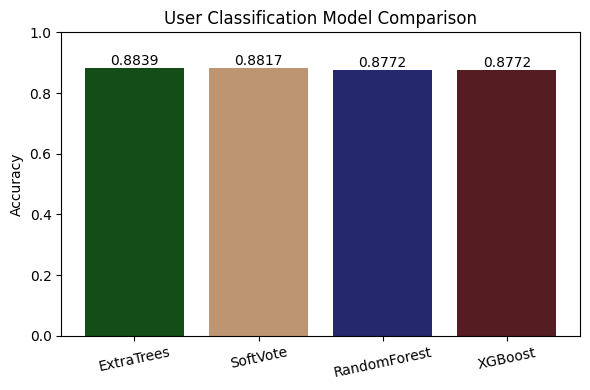

In [ ]:
# Plots
palette = {
    "ExtraTrees":   "#154d17",
    "SoftVote":     "#bd9573",
    "XGBoost":      "#541d21",
    "RandomForest": "#26286e",
}

labels = summary_gate.index
vals   = summary_gate["accuracy"].values
cols   = [palette.get(m, "#7f8c8d") for m in labels]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, vals, color=cols, linewidth=0.8)
plt.ylim(0,1); plt.ylabel("Accuracy")
plt.title(f"User Classification Model Comparison")
for i, v in enumerate(vals):
    plt.text(i, v+0.01, f"{v:.4f}", ha="center")
plt.xticks(rotation=12)
plt.tight_layout(); plt.show()

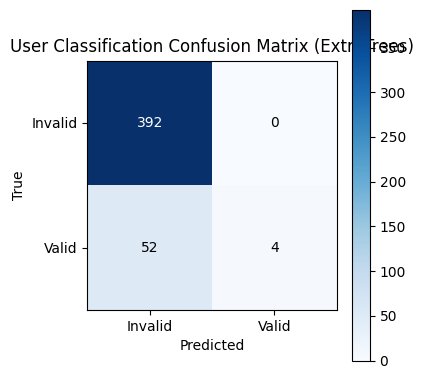

In [ ]:
best_gate = summary_gate.index[0]
cm = cm_gate[best_gate]
plt.figure(figsize=(4.2,4));
im = plt.imshow(cm, cmap="Blues")
plt.title(f"User Classification Confusion Matrix ({best_gate})")
plt.xticks([0,1],["Invalid","Valid"]); plt.yticks([0,1],["Invalid","Valid"])
for i in range(2):
    for j in range(2):
        val=int(cm[i,j]);
        plt.text(j,i,val,ha="center",va="center", color="white" if val>cm.max()/2 else "black")
plt.xlabel("Predicted");
plt.ylabel("True");
plt.colorbar(im);
plt.tight_layout();
plt.show()

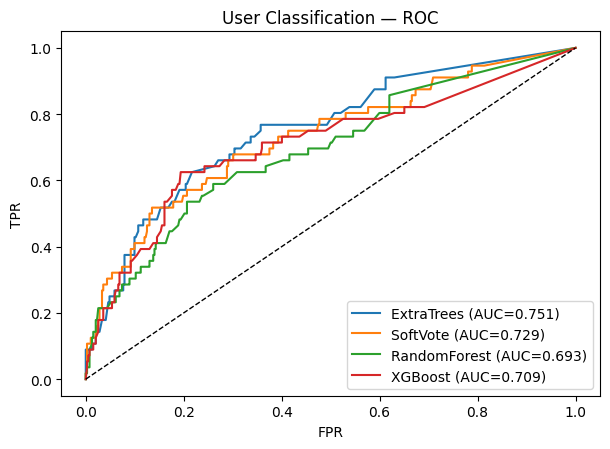

In [ ]:
plt.figure(figsize=(6.2,4.6))
for m in summary_gate.index:
    y=np.array(roc_gate[m]["y"]); s=np.array(roc_gate[m]["s"])
    if len(np.unique(y))<2: continue
    fpr,tpr,_=roc_curve(y,s); auc=roc_auc_score(y,s)
    plt.plot(fpr,tpr,label=f"{m} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.title("User Classification — ROC");
plt.legend(loc="lower right");
plt.tight_layout();
plt.show()

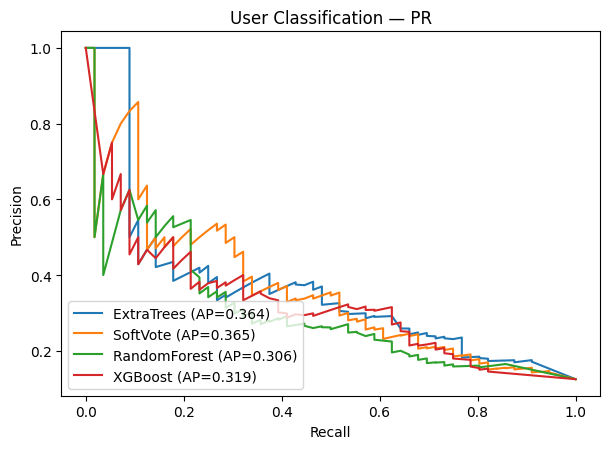

In [ ]:
plt.figure(figsize=(6.2,4.6))
for m in summary_gate.index:
    y=np.array(pr_gate[m]["y"]); s=np.array(pr_gate[m]["s"])
    if len(np.unique(y))<2: continue
    prec,rec,_=precision_recall_curve(y,s); ap=average_precision_score(y,s)
    plt.plot(rec,prec,label=f"{m} (AP={ap:.3f})")
plt.xlabel("Recall");
plt.ylabel("Precision");
plt.title("User Classification — PR");
plt.legend(loc="lower left")
plt.tight_layout();
plt.show()

# **User Identification**

In [ ]:
!pip install sktime==0.26.0

In [ ]:
!pip install numba

In [ ]:
import os, glob, warnings, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [ ]:
warnings.filterwarnings("ignore")
random.seed(42); np.random.seed(42)

In [ ]:
ROOT   = "/content/data_haptic/data_haptic"
DEFAULT_FS = 250.0
WIN_S, HOP_S = 1.2, 0.6
DOWNSAMPLE = 1
MAX_WINS_PER_REC = 16
SPLIT_MODE = "per_user_windows"
TEST_FRAC  = 0.4
N_REPEATS  = 3

In [ ]:
def list_force_files(root):
    files=[]
    for u in sorted([d for d in os.listdir(root) if d.startswith("u")]):
        upath=os.path.join(root,u)
        if not os.path.isdir(upath): continue
        for t in list("abcdefg"):
            tpath=os.path.join(upath,t)
            if not os.path.isdir(tpath): continue
            f=os.path.join(tpath,"force.csv")
            if not os.path.exists(f):
                cands=glob.glob(os.path.join(tpath,"*force*.csv"))
                if not cands: continue
                f=sorted(cands)[0]
            files.append((u,t,f))
    return files

def load_force_csv(path):
    import pandas as pd, numpy as np
    df = pd.read_csv(path)
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] < 3: num = df
    cols = {c.lower(): c for c in num.columns}
    guess = list(num.columns[-3:])
    fx = cols.get("fx") or cols.get("force_x") or cols.get("forcex") or guess[0]
    fy = cols.get("fy") or cols.get("force_y") or cols.get("forcey") or guess[1]
    fz = cols.get("fz") or cols.get("force_z") or cols.get("forcez") or guess[2]
    tt = cols.get("time") or cols.get("timestamp")
    out = pd.DataFrame({"Fx":pd.to_numeric(num[fx],errors="coerce"),
                        "Fy":pd.to_numeric(num[fy],errors="coerce"),
                        "Fz":pd.to_numeric(num[fz],errors="coerce")})
    if tt is not None and tt in num.columns:
        out["time"]=pd.to_numeric(num[tt],errors="coerce")
    return out.dropna().reset_index(drop=True)

def estimate_fs(df, default_fs=DEFAULT_FS):
    if "time" not in df.columns or len(df["time"])<2: return float(default_fs)
    t = pd.to_numeric(df["time"], errors="coerce").to_numpy()
    dt = np.diff(t); dt = dt[np.isfinite(dt) & (dt>0)]
    if dt.size == 0: return float(default_fs)
    med=float(np.median(dt))
    if not np.isfinite(med) or med<=0: return float(default_fs)
    return float(np.clip(1.0/med, 20.0, 2000.0))

In [ ]:
def _window_indices(n, win, hop):
    starts=list(range(0, max(n-win+1,1), hop))
    if starts and starts[-1] != max(n-win,0): starts.append(max(n-win,0))
    return starts or [0]

def _stats4(x):
    x = x.astype(np.float32)
    m  = float(np.mean(x))
    sd = float(np.std(x))
    pt = float(np.ptp(x)) if x.size>1 else 0.0
    rm = float(np.sqrt(np.mean(x*x)))
    return m, sd, pt, rm

def _corr(a,b):
    if a.std()==0 or b.std()==0: return 0.0
    return float(np.corrcoef(a,b)[0,1])

def _quick_feats(seg):
    Fx, Fy, Fz = seg[:,0], seg[:,1], seg[:,2]
    Fn = np.linalg.norm(seg, axis=1)
    feats=[]
    for a in (Fx, Fy, Fz, Fn):
        feats.extend(_stats4(a))
    feats.extend([_corr(Fx,Fy), _corr(Fx,Fz), _corr(Fy,Fz)])
    return np.asarray(feats, dtype=np.float32)

def build_windows(root=ROOT):
    X, meta = [], []
    rec_idx = 0
    for (u,t,fpath) in list_force_files(root):
        df = load_force_csv(fpath)
        fs = estimate_fs(df)
        S  = df[["Fx","Fy","Fz"]].to_numpy(np.float32, copy=False)
        if DOWNSAMPLE>1:
            S = S[::DOWNSAMPLE]; fs = fs/DOWNSAMPLE

        Z  = (S - S.mean(0,keepdims=True)) / (S.std(0,keepdims=True)+1e-6)

        win = max(int(round(WIN_S*fs)), 32)
        hop = max(int(round(HOP_S*fs)), 16)
        starts = _window_indices(len(Z), win, hop)
        if MAX_WINS_PER_REC and len(starts)>MAX_WINS_PER_REC:
            idx = np.linspace(0, len(starts)-1, MAX_WINS_PER_REC, dtype=int)
            starts = [starts[i] for i in idx]

        for k,st in enumerate(starts):
            seg = Z[st:st+win]
            if seg.shape[0] < win:
                pad = np.zeros((win-seg.shape[0], 3), dtype=np.float32)
                seg = np.vstack([seg, pad])
            X.append(_quick_feats(seg))
            meta.append({"user":u, "task":t, "record":fpath, "rec_idx":rec_idx, "win_id":k})
        rec_idx += 1
    X = np.stack(X, 0); meta = pd.DataFrame(meta)
    X = np.nan_to_num(X, copy=False)
    return X, meta

X, M = build_windows(ROOT)
print("Windows:", X.shape, "| records:", M['record'].nunique(), "| users:", M['user'].nunique())

Windows: (896, 19) | records: 56 | users: 8


In [ ]:
models = {
    "LinearSVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1.0, class_weight="balanced", max_iter=5000, random_state=42))
    ]),
    "HistGB": HistGradientBoostingClassifier(
        learning_rate=0.10,
        max_depth=None,
        max_iter=250,
        random_state=42
    ),
    "XGB_Softmax": XGBClassifier(
        objective="multi:softprob",
        n_estimators=300,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9, colsample_bytree=0.9,
        tree_method="hist", n_jobs=-1, random_state=42, verbosity=0
    )
}

In [ ]:
def _vote_by_record(y_win, recs):
    rec2ys = defaultdict(list)
    for y, r in zip(y_win, recs):
        rec2ys[r].append(y)
    recs_o, y_pred = [], []
    for r, L in rec2ys.items():
        recs_o.append(r)
        y_pred.append(Counter(L).most_common(1)[0][0])
    return np.array(recs_o), np.array(y_pred)

def per_user_window_splits(Mt, X_t, test_frac=0.4, repeats=3):
    rng = np.random.default_rng(42)
    for _ in range(repeats):
        tr_idx, te_idx = [], []
        for (u, rec), idx_df in Mt.groupby(["user","record"]).groups.items():
            idx = np.array(sorted(list(idx_df)))
            rng.shuffle(idx)
            nte = max(1, int(round(len(idx)*test_frac)))
            te = idx[:nte]; tr = idx[nte:] if len(idx)>nte else idx
            tr_idx.extend(tr.tolist()); te_idx.extend(te.tolist())
        yield np.array(tr_idx), np.array(te_idx)

def evaluate_user_id_fast(models, X, M, split_mode=SPLIT_MODE):
    rows = []
    id_pred_rows = []

    for task, Mt in M.groupby("task", sort=True):
        Mt = Mt.reset_index(drop=True)
        users = Mt["user"].astype(str).values
        le = LabelEncoder().fit(users)
        y  = le.transform(users)

        if split_mode == "per_record_cv":
            groups = Mt["record"].values
            if len(np.unique(groups)) < 2:
                continue
            gkf = GroupKFold(n_splits=min(2, len(np.unique(groups))))
            splits = list(gkf.split(X[Mt.index], y, groups))
        else:
            splits = list(per_user_window_splits(Mt, X[Mt.index],
                                                 test_frac=TEST_FRAC,
                                                 repeats=N_REPEATS))

        for name, est in models.items():
            y_true_rec_all, y_pred_rec_all = [], []

            for tr, te in splits:
                Xtr, Xte = X[Mt.index][tr], X[Mt.index][te]
                ytr, yte = y[tr], y[te]
                rec_te   = Mt["record"].values[te]

                clf = est
                clf.fit(Xtr, ytr)
                y_win = clf.predict(Xte)

                rec_order, y_pred_rec = _vote_by_record(y_win, rec_te)

                dfte = pd.DataFrame({"record": rec_te, "y": yte})
                y_true_rec = dfte.groupby("record")["y"].first().reindex(rec_order).values

                y_true_rec_all.extend(y_true_rec.tolist())
                y_pred_rec_all.extend(y_pred_rec.tolist())

                y_true_rec_str = le.inverse_transform(y_true_rec)
                y_pred_rec_str = le.inverse_transform(y_pred_rec)
                for r, yt_s, yp_s in zip(rec_order, y_true_rec_str, y_pred_rec_str):
                    id_pred_rows.append({
                        "task": task, "model": name, "record": r,
                        "y_true": yt_s, "y_pred": yp_s
                    })

            yt = np.array(y_true_rec_all); yp = np.array(y_pred_rec_all)
            acc = accuracy_score(yt, yp)
            pr, rc, f1, _ = precision_recall_fscore_support(yt, yp, average="macro", zero_division=0)
            rows.append({"task":task, "model":name, "accuracy":acc, "precision":pr, "recall":rc, "f1":f1})

    if id_pred_rows:
        id_preds = pd.DataFrame(id_pred_rows)
        def _mode(s): return Counter(s).most_common(1)[0][0]
        id_preds = (id_preds.groupby(["task","model","record"])
                    .agg(y_true=("y_true","first"), y_pred=("y_pred", _mode))
                    .reset_index())
    else:
        id_preds = pd.DataFrame(columns=["task","model","record","y_true","y_pred"])

    return pd.DataFrame(rows), id_preds

In [ ]:
import seaborn as sns

COLORS = {"accuracy":"#4C78A8", "precision":"#592420", "recall":"#2a702a", "f1":"#b5767e"}

def plot_confusions(id_preds, by_task=False):
    if id_preds.empty:
        print("No predictions to visualize.")
        return

    if by_task:
        groups = id_preds.groupby(["task","model"])
        title_fn = lambda t,m: f"Confusion Matrix: {m} (task {t})"
    else:
        groups = id_preds.groupby(["model"])
        title_fn = lambda m: f"Confusion Matrix: {m}"

    for key, dfm in groups:
        labels = sorted(pd.unique(pd.concat([dfm.y_true, dfm.y_pred])))
        cm = confusion_matrix(dfm.y_true, dfm.y_pred, labels=labels)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels,
                    cbar_kws={"shrink":0.8})
        plt.title(title_fn(*key) if by_task else title_fn(key))
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.show()


User Identification Metrics per task


,task,model,accuracy,precision,recall,f1
2,a,XGB_Softmax,0.9167,0.9375,0.9167,0.9143
1,a,HistGB,0.8333,0.8458,0.8333,0.8271
0,a,LinearSVC,0.7917,0.8458,0.7917,0.7664
5,b,XGB_Softmax,0.9167,0.9375,0.9167,0.9143
4,b,HistGB,0.8333,0.8458,0.8333,0.8271
3,b,LinearSVC,0.7917,0.8458,0.7917,0.7664
8,c,XGB_Softmax,0.9167,0.9375,0.9167,0.9143
7,c,HistGB,0.8333,0.8458,0.8333,0.8271
6,c,LinearSVC,0.7917,0.8458,0.7917,0.7664
11,d,XGB_Softmax,0.9167,0.9375,0.9167,0.9143



User Identification Metrics across tasks


,accuracy,precision,recall,f1
model,,,,
XGB_Softmax,0.9167,0.9375,0.9167,0.9143
HistGB,0.8333,0.8458,0.8333,0.8271
LinearSVC,0.7917,0.8458,0.7917,0.7664


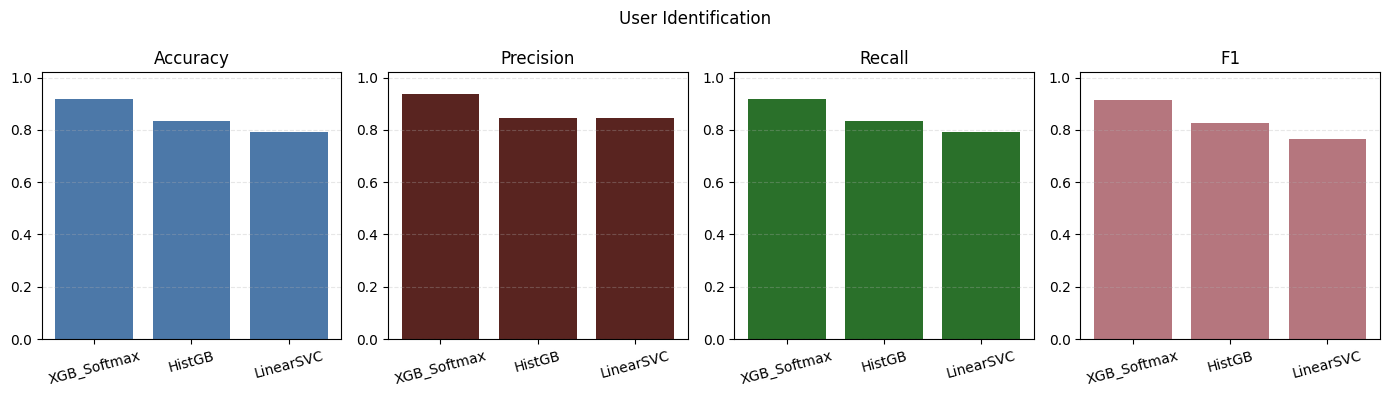

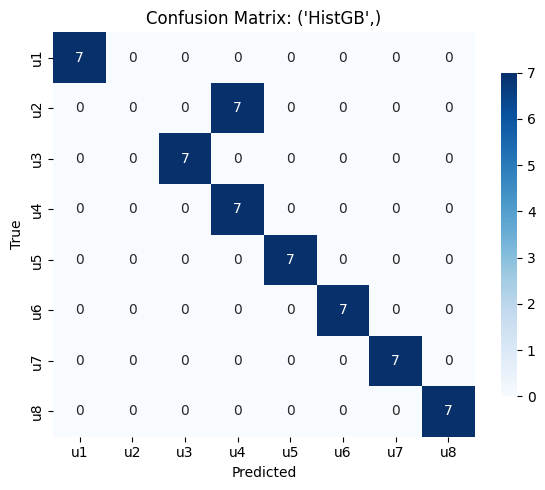

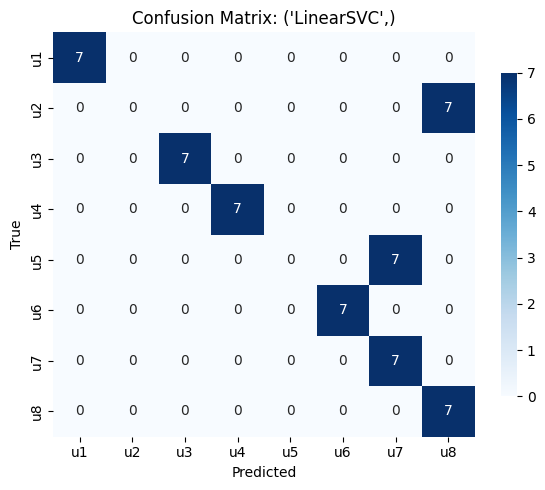

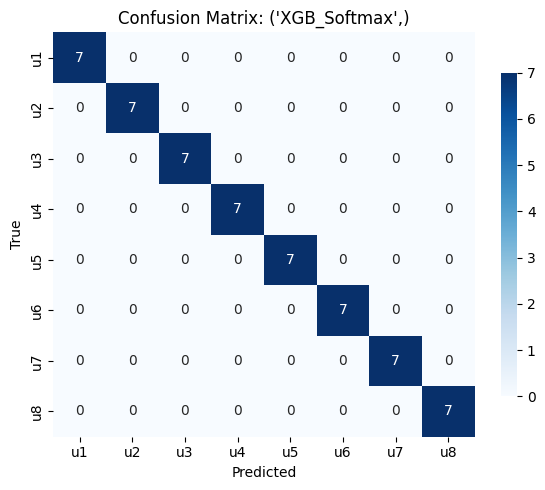

In [ ]:
res, id_preds = evaluate_user_id_fast(models, X, M, split_mode=SPLIT_MODE)

print("\nUser Identification Metrics per task")
display(res.sort_values(["task","accuracy"], ascending=[True,False]).round(4))

summary = (res.groupby("model")[["accuracy","precision","recall","f1"]]
           .mean().sort_values("accuracy", ascending=False))
print("\nUser Identification Metrics across tasks")
display(summary.round(4))

fig, axes = plt.subplots(1,4, figsize=(14,4), sharex=True)
for i, metric in enumerate(["accuracy","precision","recall","f1"]):
    axes[i].bar(summary.index, summary[metric].values,
                color=COLORS[metric], linewidth=0.5)
    axes[i].set_title(metric.title()); axes[i].set_ylim(0,1.02)
    axes[i].grid(axis="y", ls="--", alpha=0.3)
    axes[i].tick_params(axis='x', rotation=15)
plt.suptitle(f"User Identification")
plt.tight_layout();
plt.show()

plot_confusions(id_preds, by_task=False)